# Develop Model

In this noteook, we will go through the steps to load the ResNet152 model, pre-process the images to the required format and call the model to find the top predictions.

In [1]:
import PIL
import numpy as np
import torch
import torch.nn as nn
import torchvision
import wget
from PIL import Image
from torchvision import models, transforms

In [2]:
print(torch.__version__)
print(torchvision.__version__)

0.4.1.post2
0.2.1


We download the synset for the model. This translates the output of the model to a specific label.

In [3]:
!wget "http://data.dmlc.ml/mxnet/models/imagenet/synset.txt"

--2018-11-06 18:18:03--  http://data.dmlc.ml/mxnet/models/imagenet/synset.txt
Resolving data.dmlc.ml... 54.208.175.7
Connecting to data.dmlc.ml|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31675 (31K) [text/plain]
Saving to: ‘synset.txt.5’

synset.txt.5        100%[===================>]  30.93K  --.-KB/s    in 0s      

2018-11-06 18:18:03 (603 MB/s) - ‘synset.txt.5’ saved [31675/31675]



We first load the model which we imported torchvision. This can take about 10s.

In [4]:
%%time
model = models.resnet152(pretrained=True)

CPU times: user 1.88 s, sys: 474 ms, total: 2.35 s
Wall time: 22.9 s


You can print the summary of the model in the below cell. We cleared the output here for brevity. When you run the cell you should see a list of the layers and the size of the model in terms of number of parameters at the bottom of the output.

In [5]:
model=model.cuda()

In [6]:
print(model)
print('Number of parameters {}'.format(sum([param.view(-1).size()[0] for param in model.parameters()])))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Let's test our model with an image of a Lynx.

In [7]:
wget.download('https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg')

'220px-Lynx_lynx_poing (5).jpg'

(220, 330)


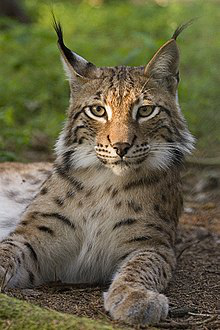

In [8]:
img_path = '220px-Lynx_lynx_poing.jpg'
print(Image.open(img_path).size)
Image.open(img_path)

Below, we load the image. Then we compose transformation which resize the image to (224, 224) and then convert it to a PyTorch tensor and normalize the pixel values.

In [9]:
img = Image.open(img_path).convert('RGB')

In [10]:
preprocess_input = transforms.Compose([
    torchvision.transforms.Resize((224, 224), interpolation=PIL.Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
img = Image.open(img_path)
img = preprocess_input(img)

Let's make a label look up function to make it easy to lookup the classes from the synset file

In [12]:
def create_label_lookup():
    with open('synset.txt', 'r') as f:
        label_list = [l.rstrip() for l in f]
    def _label_lookup(*label_locks):
        return [label_list[l] for l in label_locks]
    return _label_lookup

In [13]:
label_lookup = create_label_lookup()

We will apply softmax to the output of the model to get probabilities for each label.  Softmax calculates probabilities.

In [14]:
softmax = nn.Softmax(dim=1).cuda()

Now, let's call the model on our image to predict the top 3 labels. This will take a few seconds.

In [15]:
model = model.eval()

In [16]:
%%time
#skip gradients, forward only computation
with torch.no_grad():
    img = img.unsqueeze(0)
    image_gpu = img.type(torch.float).cuda()
    outputs = model(image_gpu)
    probabilities = softmax(outputs)

CPU times: user 28 ms, sys: 3.86 ms, total: 31.9 ms
Wall time: 1.11 s


In [17]:
label_lookup = create_label_lookup()

In [18]:
#remove batch size (1), so we should be back to (3, 224, 224)
probabilities_numpy = probabilities.cpu().numpy().squeeze()

In [19]:
top_results = np.flip(np.sort(probabilities_numpy), 0)[:3]

In [20]:
labels = label_lookup(*np.flip(probabilities_numpy.argsort(),0)[:3])

In [21]:
dict(zip(labels, top_results))

{'n02127052 lynx, catamount': 0.9966714,
 'n02123159 tiger cat': 0.001128194,
 'n02128385 leopard, Panthera pardus': 0.00072955893}

The top guess is Lynx with probability about 99%. We can now move on to [developing the model api for our model](01_DevelopModelDriver.ipynb).